In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMapWithTime

In [3]:
vehicles = pd.read_csv('./Data/Transportation_Network_Providers_-_Vehicles.csv')
vehicles.head()

,MONTH_REPORTED,STATE,MAKE,MODEL,COLOR,YEAR,LAST_INSPECTION_MONTH,NUMBER_OF_TRIPS,MULTIPLE_TNPS
0,2017-09,IL,Nissan,Pathfinder,Red,2016.0,2017-06,NaN,True
1,2016-10,IL,Nissan,Altima,NaN,2016.0,NaN,NaN,True
2,2018-01,IL,Nissan,Altima,Gray,2014.0,2017-10,NaN,True
3,2015-12,IL,Toyota,Prius,NaN,2010.0,NaN,0.0,False
4,2017-10,IL,Toyota,Camry,Gray,2012.0,2017-09,NaN,True


In [4]:
vehicles.isna().sum()

MONTH_REPORTED                 0
STATE                      14210
MAKE                        5035
MODEL                       5053
COLOR                     817702
YEAR                        5031
LAST_INSPECTION_MONTH    2932401
NUMBER_OF_TRIPS            10786
MULTIPLE_TNPS                  0
dtype: int64

In [5]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5924492 entries, 0 to 5924491
Data columns (total 9 columns):
MONTH_REPORTED           object
STATE                    object
MAKE                     object
MODEL                    object
COLOR                    object
YEAR                     float64
LAST_INSPECTION_MONTH    object
NUMBER_OF_TRIPS          float64
MULTIPLE_TNPS            bool
dtypes: bool(1), float64(2), object(6)
memory usage: 367.3+ MB


In [31]:
def pre_process(df):
    df = df.dropna(subset=["YEAR"])
    df['NUMBER_OF_TRIPS'] = df['NUMBER_OF_TRIPS'].fillna(value=1000)
    df = df.reset_index(drop=True)
    df['YEAR'] = df['YEAR'].astype(int)
    df['MONTH_REPORTED'] = pd.to_datetime(df['MONTH_REPORTED'], format='%Y-%m')
    df['LAST_INSPECTION_MONTH'] = pd.to_datetime(df['LAST_INSPECTION_MONTH'], format='%Y-%m')
    df['Time_ISP_REP'] = (df['MONTH_REPORTED'] - df['LAST_INSPECTION_MONTH']).dt.days
    
    df['MAKE'] = df['MAKE'].replace({'Mercedesbenz': 'Mercedes-Benz',
                                                 'Mercedes Benz': 'Mercedes-Benz',
                                                 'Mercedes': 'Mercedes-Benz',
                                    'Ram Trucks': 'Ram'})
    
    df['MODEL'] = df['MODEL'].replace({'Mazda3': '3', 'Prius C': 'Prius', 'Prius V': 'Prius'})
    df = df.loc[df['NUMBER_OF_TRIPS']>10]
    df = df.groupby(["MAKE", 'MODEL','YEAR']).filter(lambda x: len(x) > 500)
    df=df.reset_index(drop=True)
    return df

In [32]:
vehicles = pd.read_csv('./Data/Transportation_Network_Providers_-_Vehicles.csv')
vehicles = pre_process(vehicles)
vehicles.info()

/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327090 entries, 0 to 2327089
Data columns (total 10 columns):
MONTH_REPORTED           datetime64[ns]
STATE                    object
MAKE                     object
MODEL                    object
COLOR                    object
YEAR                     int64
LAST_INSPECTION_MONTH    datetime64[ns]
NUMBER_OF_TRIPS          float64
MULTIPLE_TNPS            bool
Time_ISP_REP             float64
dtypes: bool(1), datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 162.0+ MB


In [33]:
high_trip_veh = vehicles.loc[(vehicles['NUMBER_OF_TRIPS']==1000)]
high_trip_veh_sum = high_trip_veh.groupby(['MAKE','MODEL'])['NUMBER_OF_TRIPS'].agg(['count']).sort_values(['count'], ascending=False)
high_trip_veh_sum['Percentage_of_High_Trip_Vehicles'] = high_trip_veh_sum['count']*100/high_trip_veh_sum['count'].sum()
high_trip_veh_sum = high_trip_veh_sum.reset_index()
high_trip_veh_sum.head(10)

,MAKE,MODEL,count,Percentage_of_High_Trip_Vehicles
0,Toyota,Camry,1070,12.317256
1,Toyota,Prius,1023,11.776217
2,Lincoln,Mkz,560,6.446414
3,Dodge,Grand Caravan,557,6.411880
4,Toyota,Corolla,379,4.362841
5,Hyundai,Elantra,348,4.005986
6,Hyundai,Sonata,253,2.912398
7,Nissan,Altima,237,2.728215
8,Nissan,Sentra,215,2.474963
9,Honda,Accord,171,1.968459


In [34]:
veh_sum=vehicles.groupby(['MAKE','MODEL'])['NUMBER_OF_TRIPS'].agg(['count']).sort_values(['count'], ascending=False)
veh_sum['Sum_Trips'] = vehicles.groupby(['MAKE','MODEL'])['NUMBER_OF_TRIPS'].agg(['sum']).sort_values(['sum'])
veh_sum['Mean_Trips'] = vehicles.groupby(['MAKE','MODEL'])['NUMBER_OF_TRIPS'].agg(['mean']).sort_values(['mean'])
veh_sum = veh_sum.reset_index()
veh_sum.sort_values(by=['Mean_Trips'], ascending=False).head(10)

,MAKE,MODEL,count,Sum_Trips,Mean_Trips
139,Nissan,Leaf,780,243470.0,312.141026
35,Lincoln,Mkz,17395,4259081.0,244.845128
3,Toyota,Prius,109064,20561165.0,188.523848
162,Toyota,Rav 4,542,101962.0,188.121771
0,Toyota,Camry,209369,38195429.0,182.431157
166,Ford,Cmax,533,95875.0,179.878049
70,Infiniti,Qx60,5470,976930.0,178.597806
83,Ford,Fusion Hybrid,4313,717948.0,166.461396
9,Hyundai,Elantra,70692,11730663.0,165.940460
2,Toyota,Corolla,109633,18113776.0,165.221931


In [35]:
veh_sum_year=vehicles.groupby(['YEAR'])['NUMBER_OF_TRIPS'].agg(['count']).sort_values(['count'], ascending=False)
veh_sum_year['Sum_Trips'] = vehicles.groupby(['YEAR'])['NUMBER_OF_TRIPS'].agg(['sum']).sort_values(['sum'])
veh_sum_year['Mean_Trips'] = vehicles.groupby(['YEAR'])['NUMBER_OF_TRIPS'].agg(['mean']).sort_values(['mean'])
veh_sum_year = veh_sum_year.reset_index()
veh_sum_year.sort_values(by=['Mean_Trips'], ascending=False).tail(10)

,YEAR,count,Sum_Trips,Mean_Trips
10,2009,85951,11692793.0,136.040221
9,2008,99437,13479151.0,135.554683
6,2011,139967,18821299.0,134.469546
3,2013,239336,32150066.0,134.330255
5,2012,181899,24234897.0,133.232712
13,2005,51358,6781134.0,132.036567
12,2006,65292,8486567.0,129.978665
16,2003,9880,1283167.0,129.875202
17,2002,2459,314961.0,128.084994
14,2004,29445,3735109.0,126.850365


/opt/conda/envs/data3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(2002, 2020)

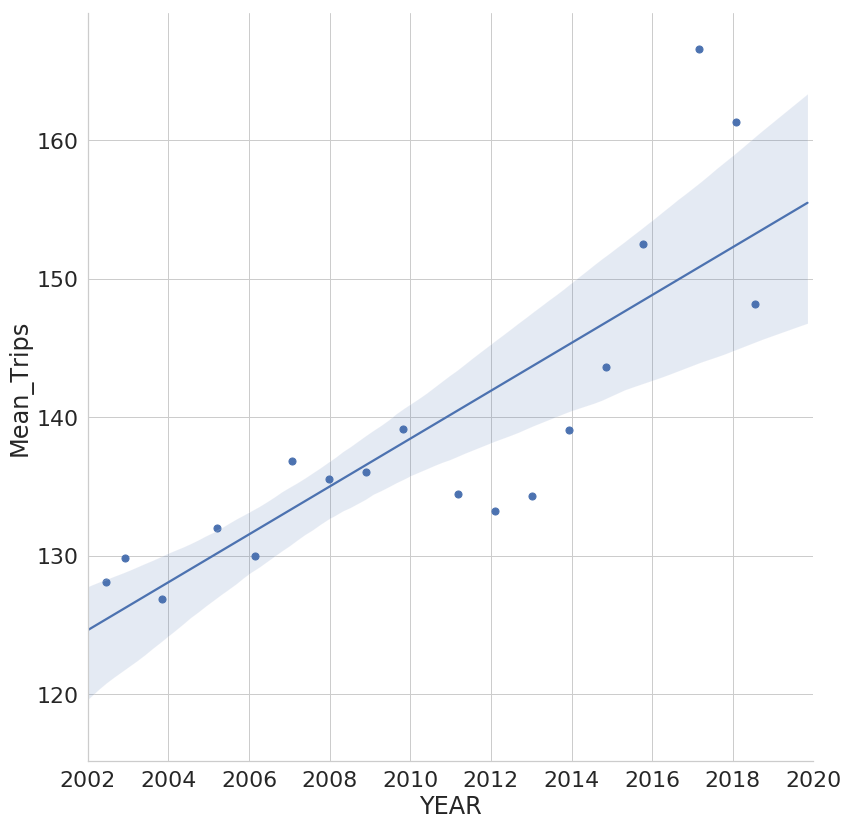

In [97]:
sns.set(font_scale=2)
sns.set_style('whitegrid')
sns.lmplot(y='Mean_Trips', x='YEAR', data=veh_sum_year,x_bins=36, height=12)
plt.xlim(2002,2020)

In [76]:
high_trip_veh_year = high_trip_veh.groupby(['YEAR'])['NUMBER_OF_TRIPS'].agg(['count']).sort_values(['count'], ascending=False)
high_trip_veh_year['Percentage_of_High_Trip_Vehicles'] = high_trip_veh_year['count']*100/high_trip_veh_year['count'].sum()
high_trip_veh_year = high_trip_veh_year.reset_index()
high_trip_veh_year.1(10)

,YEAR,count,Percentage_of_High_Trip_Vehicles
8,2008,345,3.971452
9,2007,344,3.959940
10,2018,291,3.349833
11,2009,259,2.981467
12,2006,211,2.428917
13,2005,180,2.072062
14,2004,101,1.162657
15,2003,47,0.541038
16,2019,22,0.253252
17,2002,15,0.172672


/opt/conda/envs/data3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(2002, 2020)

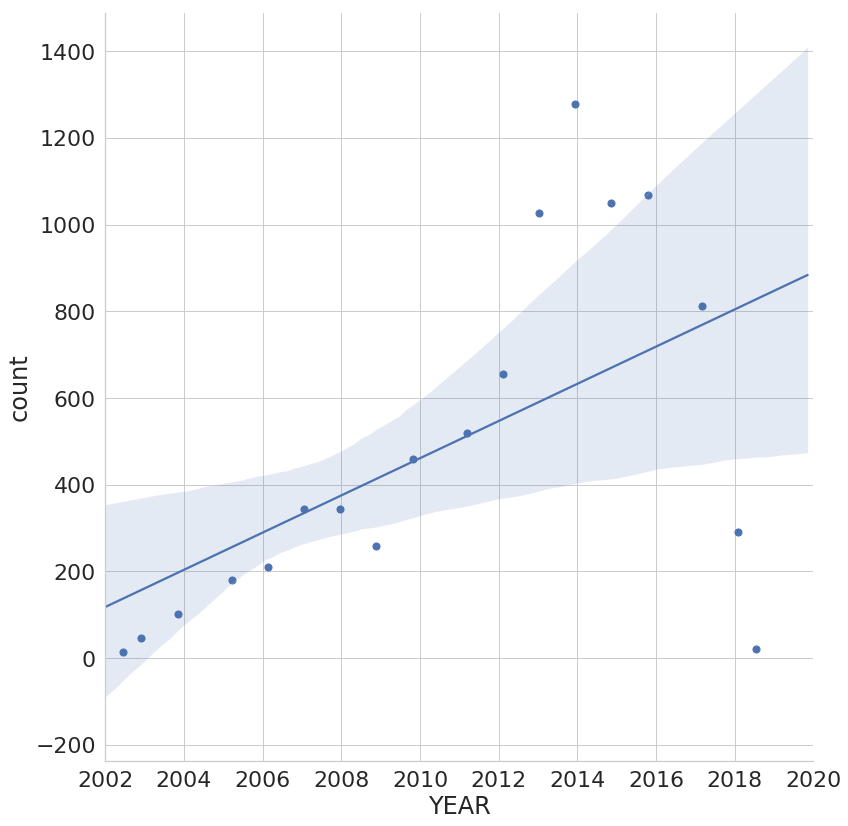

In [96]:
#fig = plt.figure(figsize=(15,15))
sns.set(font_scale=2)
sns.set_style('whitegrid')
sns.lmplot(y='count', x='YEAR', data=high_trip_veh_year,x_bins=36, height=12)
plt.xlim(2002,2020)

In [99]:
merged_veh_sum = pd.merge(high_trip_veh_sum, veh_sum, on=["MAKE",'MODEL'])
merged_veh_sum['Percentage_of_HT_Veh_Total'] = merged_veh_sum['count_x']*100/merged_veh_sum['count_y']
merged_veh_sum = merged_veh_sum.round(2)

merged_veh_sum.sort_values(by=['Percentage_of_HT_Veh_Total'], ascending=False).head(10).to_excel("./Data/top_10.xlsx")

In [105]:
merged_veh_sum.head()

,MAKE,MODEL,count_x,Percentage_of_High_Trip_Vehicles,count_y,Sum_Trips,Mean_Trips,Percentage_of_HT_Veh_Total
0,Toyota,Camry,1070,12.32,209369,38195429.0,182.43,0.51
1,Toyota,Prius,1023,11.78,109064,20561165.0,188.52,0.94
2,Lincoln,Mkz,560,6.45,17395,4259081.0,244.85,3.22
3,Dodge,Grand Caravan,557,6.41,32051,5224459.0,163.00,1.74
4,Toyota,Corolla,379,4.36,109633,18113776.0,165.22,0.35


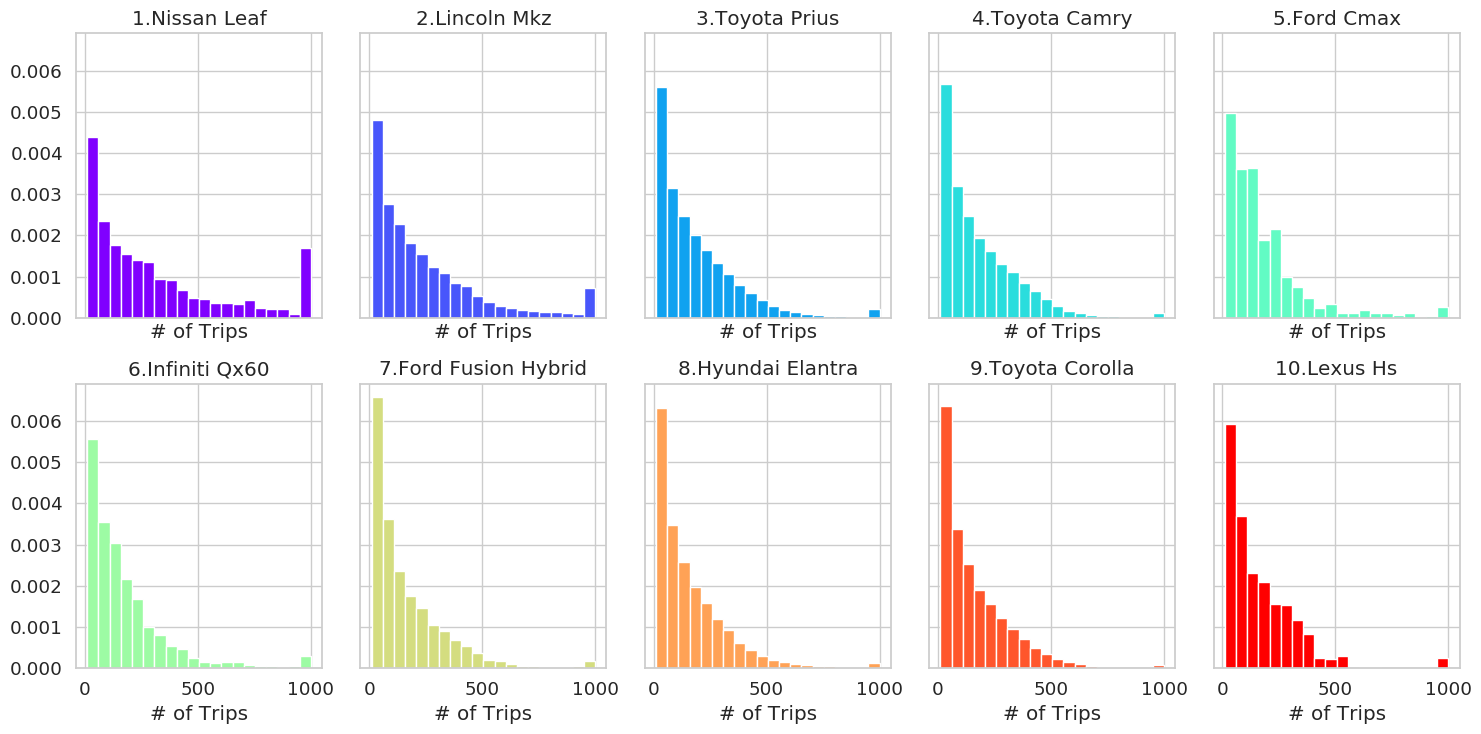

In [106]:
import matplotlib.cm as cm
sns.set(font_scale=1.2)
sns.set_style('whitegrid')
top_10 = merged_veh_sum.sort_values(by=['Mean_Trips'], ascending=False).head(10)
top_10 = top_10.reset_index()
plt.rcParams.update({'font.size': 12})

#kwargs = dict(alpha=1, bins=100,density=True, stacked=True)

fig, axes = plt.subplots(2, 5, figsize=(15,7.5), dpi=100, sharex=True, sharey=True)
colors = cm.rainbow(np.linspace(0, 1, len(top_10)))

for i,(ax,make, model) in enumerate(zip(axes.flatten(), top_10['MAKE'],top_10['MODEL'])):
    df= vehicles.loc[(vehicles['MAKE'] == make) & (vehicles['MODEL'] ==model), 'NUMBER_OF_TRIPS']
    lab = make + ' ' + model
    ax.hist(df, alpha=1, bins=20,color=colors[i],density=True, stacked=True)
    ax.set_xlabel('# of Trips')
    
    ax.set_title(str(i+1)+'.' + lab)
plt.tight_layout();


/opt/conda/envs/data3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


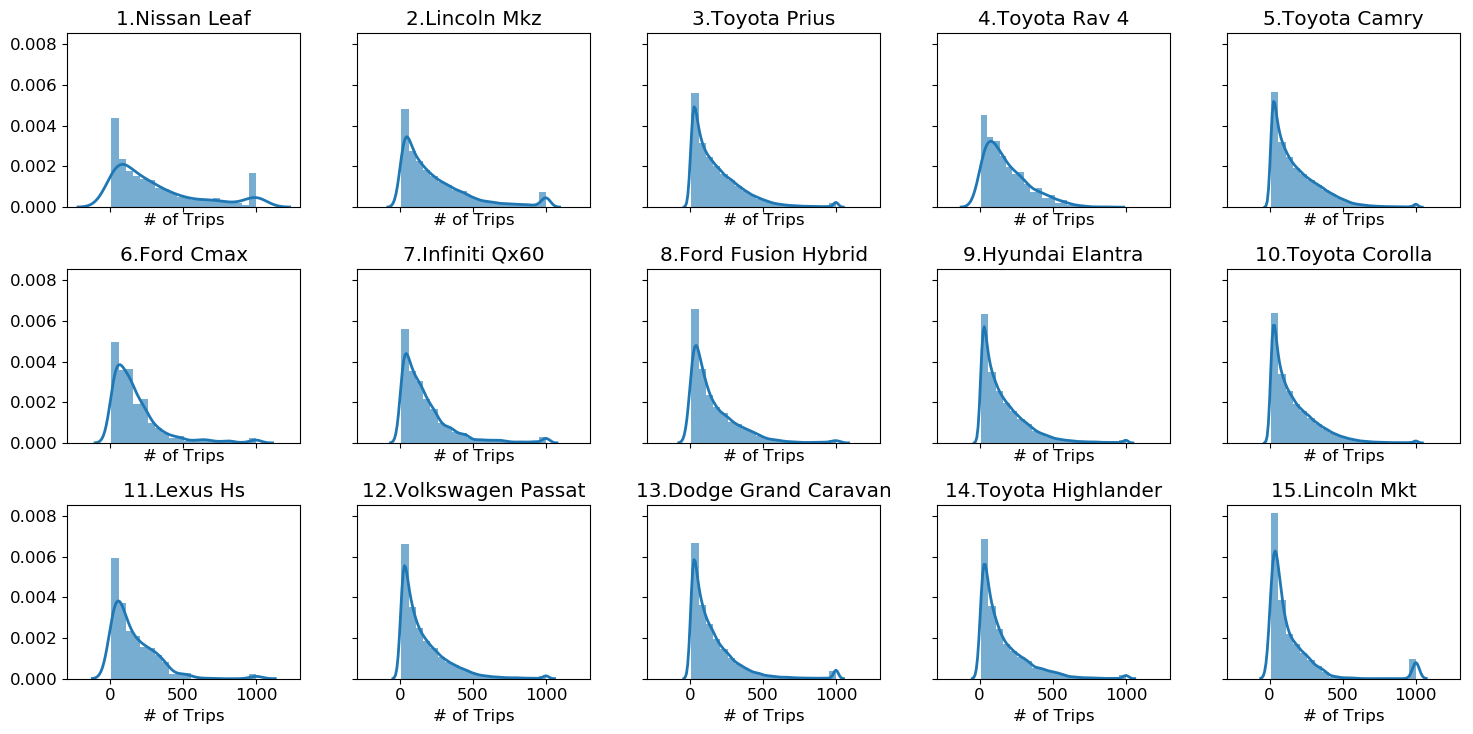

In [92]:
import matplotlib.cm as cm

top_15 = veh_sum.sort_values(by=['Mean_Trips'], ascending=False).head(15)
top_15 = top_15.reset_index()
plt.rcParams.update({'font.size': 12})

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

fig, axes = plt.subplots(3, 5, figsize=(15,7.5), dpi=100, sharex=True, sharey=True)
colors = cm.rainbow(np.linspace(0, 1, len(top_15)))

for i,(ax,make, model) in enumerate(zip(axes.flatten(), top_15['MAKE'],top_15['MODEL'])):
    df= vehicles.loc[(vehicles['MAKE'] == make) & (vehicles['MODEL'] ==model), 'NUMBER_OF_TRIPS']
    lab = make + ' ' + model
    sns.distplot(df , ax=ax,bins=20,norm_hist=True,**kwargs)
    ax.set_xlabel('# of Trips')
    
    ax.set_title(str(i+1)+'.' + lab)
plt.tight_layout();


In [13]:
from sklearn import base

class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X):
        return X[self.col_names].values

In [14]:
cat_features = ['MAKE', 'MODEL','MULTIPLE_TNPS']

num_features = ['YEAR']

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

CST = ColumnSelectTransformer(num_features)
num_pipeline = Pipeline([('attribs_adder', CST),
        ('std_scaler', StandardScaler())])

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", OneHotEncoder(sparse=False), cat_features)])

In [27]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

size = 250000

vehicles_prep = vehicles.drop(columns=['STATE', 'COLOR', 'MONTH_REPORTED','LAST_INSPECTION_MONTH'])

X_prep = vehicles_prep[:size]
y = X_prep['NUMBER_OF_TRIPS'].values
X_prep = X_prep.drop(columns=['NUMBER_OF_TRIPS'])
X = full_pipeline.fit_transform(X_prep)

X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, test_size=0.2, random_state=42)

        



In [156]:

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


models = []
models.append(('LR', LinearRegression()))

models.append(('GBR', GradientBoostingRegressor()))

models.append(('RF', RandomForestRegressor()))


for name, model in models:
    model.fit(X_train,y_train)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    msg = "%s: %f %f (%f)" % (name, np.sqrt(-cv_results.mean()),score, cv_results.std())
    print(msg)

LR: 59.339266 3544.092680 (60.153958)
GBR: 59.073239 3507.929031 (58.950942)


/opt/conda/envs/data3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF: 59.148348 3501.576291 (62.577439)


In [ ]:
RF = RandomForestRegressor(n_estimators=100)
param_grid = [
    
    {'n_estimators': [10,50,100],
     'max_features': [2, 3, 4],
        'max_depth': [10,50,100]},
  ]

grid_search = GridSearchCV(RF, param_grid=param_grid, cv= 5)
grid_search.fit(X_train, y_train)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)